In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [2]:
data_spital = gpd.read_file('geodata/data_spital.gpkg')

# Quelle: Stadt Zürich

DriverError: geodata/data_spital.gpkg: No such file or directory

In [5]:
data_strassen = gpd.read_file('geodata/data_Strassenlaerm.gpkg')



In [6]:
data_haltestellen = gpd.read_file('geodata/Haltestellen_des_offentlichen_Verkehrs_-OGD.gpkg')

In [13]:
# Check the type of geometry
print(data_strassen.geometry.geom_type.unique())

['Point']


In [34]:
data_immoscout24 = pd.read_csv('immoscout24_geocoded_2.csv',  sep="|")


In [35]:
data_immoscout24.columns

Index(['page', 'type', 'price', 'address_x', 'description', 'weblink', 'rooms',
       'size', 'price2', '1 zimmer', '1.5 zimmer', '13 zimmer', '2 zimmer',
       '2.5 zimmer', '20 zimmer', '3 zimmer', '3.5 zimmer', '4 zimmer',
       '4.5 zimmer', '5 zimmer', '5.5 zimmer', '6 zimmer', '6.5 zimmer',
       '7 zimmer', 'address_short_1', 'address_short_2', 'size_num',
       'address_y', 'latitude', 'longitude', 'detail'],
      dtype='object')

In [36]:

# Check if the coordinate columns exist
if 'latitude' in data_immoscout24.columns and 'longitude' in data_immoscout24.columns:
    # Create a new column 'geometry' with Point geometries from latitude and longitude
    data_immoscout24['geometry'] = data_immoscout24.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
    
    # Convert the DataFrame to a GeoDataFrame
    gdf_immoscout24 = gpd.GeoDataFrame(data_immoscout24, geometry='geometry')

    # Set the coordinate reference system (CRS) for the GeoDataFrame if you know it
    gdf_immoscout24.crs = "EPSG:4326"  # WGS 84 - latitude and longitude
else:
    print("The DataFrame does not have the required coordinate columns.")

c:\Users\gigim\anaconda3\envs\mlpenv\Lib\site-packages\shapely\measurement.py:106: RuntimeWarning: invalid value encountered in bounds
  return lib.bounds(geometry_arr, out=out, **kwargs)


<Axes: >

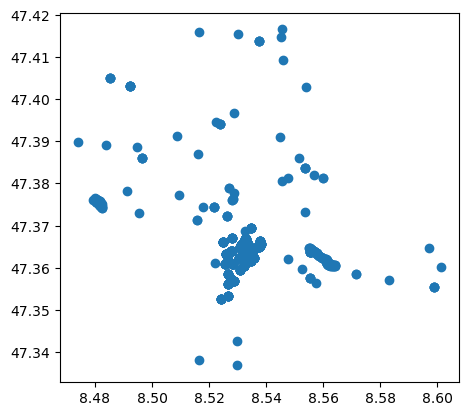

In [37]:
gdf_immoscout24.plot()

In [16]:
# Access the x (longitude) and y (latitude) coordinates of the first geometry
x, y = data_strassen.geometry.iloc[0].x, data_strassen.geometry.iloc[0].y
print("Longitude:", x)
print("Latitude:", y)

Longitude: 2686958.4477999993
Latitude: 1246277.8438000008


<Axes: >

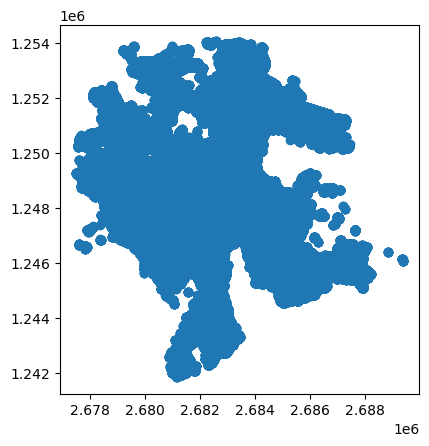

In [17]:
data_strassen.plot()

In [72]:
data_strassen[:150].to_clipboard()

c:\Users\gigim\anaconda3\envs\mlpenv\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\gigim\AppData\Local\Temp\ipykernel_13928\1263112231.py:20: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2056
Right CRS: None

  join = gpd.sjoin(gdf, grid, how='inner', op='intersects')


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
14755   NaN
14756   NaN
14757   NaN
14758   NaN
14759   NaN
Name: lr_day_avg, Length: 14760, dtype: float64


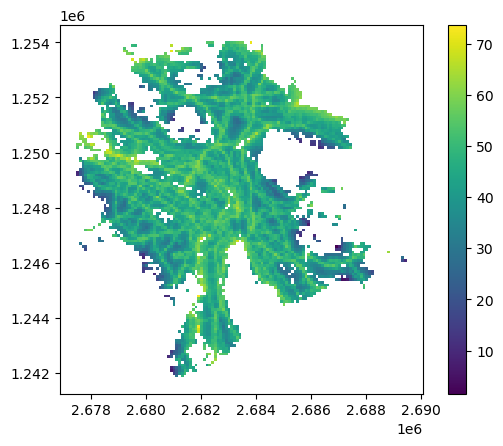

In [64]:
# Load data into a GeoDataFrame
gdf = data_strassen
# Define the extent of your grid
xmin, ymin, xmax, ymax = gdf.total_bounds
width = height = 100  # grid cell size in your units, adjust as necessary

# Create the grid cells
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), height))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append(Polygon([(x,y), (x+width, y), (x+width, y-height), (x, y-height)]))

grid = gpd.GeoDataFrame({'geometry':polygons})

# Perform spatial join
join = gpd.sjoin(gdf, grid, how='inner', op='intersects')

# Calculate the averages by grid cell
average_values = join.groupby(join.index_right).agg({'lr_day':'mean', 'lr_night':'mean'})

# Join the averages back to the grid
grid['lr_day_avg'] = average_values['lr_day']
grid['lr_night_avg'] = average_values['lr_night']

# Plot the grid
grid.plot(column='lr_day_avg', legend=True)
print(grid['lr_day_avg'])

c:\Users\gigim\anaconda3\envs\mlpenv\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\gigim\AppData\Local\Temp\ipykernel_13928\2823178222.py:25: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:2056
Right CRS: EPSG:4326

  join = gpd.sjoin(gdf, grid, how='inner', op='intersects')


ValueError: aspect must be finite and positive 

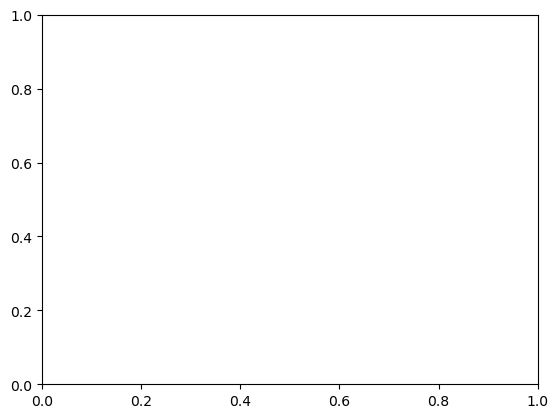

In [66]:
# Load data into a GeoDataFrame
gdf = data_strassen
# Define the extent of your grid
xmin, ymin, xmax, ymax = gdf.total_bounds
width = height = 100  # grid cell size in your units, adjust as necessary

# Create the grid cells
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), height))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append(Polygon([(x,y), (x+width, y), (x+width, y-height), (x, y-height)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
# Check if the CRS is defined for the grid
if grid.crs is None:
    # If it's not defined, set the CRS for the grid too.
    grid.set_crs("EPSG:4326", inplace=True)  # Replace 'EPSG:4326' with the grid's correct CRS.


# Perform spatial join
join = gpd.sjoin(gdf, grid, how='inner', op='intersects')

# Calculate the averages by grid cell
average_values = join.groupby(join.index_right).agg({'lr_day':'mean', 'lr_night':'mean'}).reset_index()
# Rename the column 'index_right' to match the index name of grid for the merge
average_values.rename(columns={'index_right': 'index'}, inplace=True)

# Merge the averages with the grid DataFrame on the index
grid = grid.merge(average_values, how='left', left_on=grid.index, right_on='index')

# Plot the grid
grid.plot(column='lr_day_avg', legend=True)
print(grid['lr_day_avg'])

In [85]:
### stuffe

# Load data into a GeoDataFrame
gdf = data_strassen
gdf.set_crs("EPSG:4326", allow_override=True) # Only if the data is in lon/lat format
# Define the extent of your grid
xmin, ymin, xmax, ymax = gdf.total_bounds
width = height = 500  # grid cell size in your units, adjust as necessary

# Create the grid cells
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), width))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), height))
rows.reverse()

# Aggregate data by some logical division, e.g., regions or categories, before the join
aggregated_gdf = gdf.groupby('lr_day').agg({'geometry': 'first', 'data_value': 'mean'}).reset_index()
#aggregated_gdf = gdf.groupby('lr_night').agg({'geometry': 'first', 'data_value': 'mean'}).reset_index()

polygons = []
for x in cols:
    for y in rows:
        polygons.append(Polygon([(x,y), (x+width, y), (x+width, y-height), (x, y-height)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
# If the CRS is not set for `grid`, set it to match `gdf`
if grid.crs != gdf.crs:
    grid.set_crs(gdf.crs, inplace=True)

# This should be the grid, then the points, not points then grid
join = gpd.sjoin(grid, gdf, how='left', predicate='intersects')

print(join.columns)
# Output the number of intersections per grid cell to investigate overlaps
intersection_counts = join['index_right'].value_counts()
print(intersection_counts.describe())

# Ensure the groupby operation sets the index correctly for merging
average_values = join.groupby('index_right').agg({'lr_day': 'mean', 'lr_night': 'mean'}).reset_index()
average_values.rename(columns={'index_right': 'index'}, inplace=True)

# Merge using explicit indices if they are indeed meant to be the same
grid = grid.merge(average_values, how='right', left_on=grid.index, right_on='index')

print('grid columns:', grid.columns)
# If the CRS is not set for `grid`, set it to match `gdf`
if grid.crs != gdf.crs:
    grid.set_crs(gdf.crs, inplace=True)
# Plot the grid
grid.plot(column='lr_day', legend=True)
print(grid['lr_night'])

KeyError: "Column(s) ['data_value'] do not exist"

In [74]:
grid['lr_night_avg']

KeyError: 'lr_night_avg'

ValueError: aspect must be finite and positive 

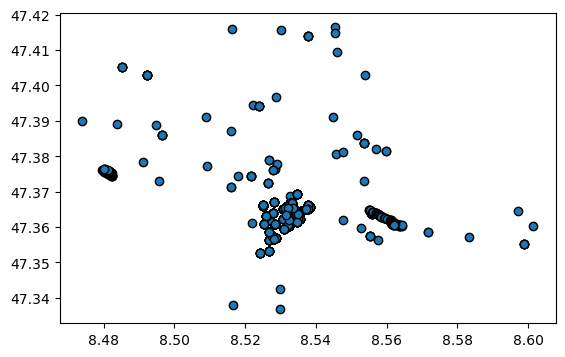

In [54]:
gdf_immoscout24.set_crs("EPSG:4326", inplace=True) # Only if the data is in lon/lat format
grid.set_crs("EPSG:4326", inplace=True)

# Check if the CRS is defined for your original GeoDataFrame
if gdf_immoscout24.crs is None:
    # If it's not defined, set the CRS. Replace 'EPSG:4326' with the correct CRS.
    gdf_immoscout24.set_crs("EPSG:4326", inplace=True)

# Check if the CRS is defined for the grid
if grid.crs is None:
    # If it's not defined, set the CRS for the grid too.
    grid.set_crs("EPSG:4326", inplace=True)  # Replace 'EPSG:4326' with the grid's correct CRS.


# Ensure both GeoDataFrames use the same CRS
gdf_immoscout24 = gdf_immoscout24.to_crs(grid.crs)

# Plot the first layer

ax = gdf_immoscout24.plot(edgecolor='k')


# Overlay the second layer, using 'column' to define colors
grid.plot(ax=ax, alpha=0.5, column='lr_day_avg', legend=True)


# Optional: Set the axes limits if you want to zoom to a specific area
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])

# Optional: Add additional plot parameters
plt.title('Overlay of Two Datasets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()